# Babazon Recommender System

<b>Author:</b> Can Gök

<b>Description:</b> This project takes data of Babazon E-Commerce System's customers which has 7 categories. Recommender system will take the customer's purchased products and will recommend a new category to the customer.

This project uses <b>Tensorflow</b>.

- Import the libraries.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

- Create a data frame, this data frame will be the training data of the recommender system.

In [2]:
user = []
categories = [1,2,3,4,5,6,7]
category = []
rating = [1,0,3,2,2,3,1,1,2,3,0,3,0,2,0,1,3,0,2,2,3,0,2,0,2,3,3,3,1,0,0,0,3,0,3,0,1,1,0,2,0,1,0,0,3,2,3,1,3,0,0,0,0,0,0,1]
for i in range((int)(len(rating)/7)):
    temp = [i+1 for x in range(7)]
    user += temp
    category += categories
data = {'UserID': user, 'Category': category, 'Rating': rating}
df = pd.DataFrame(data)
df.head()

,UserID,Category,Rating
0,1,1,1
1,1,2,0
2,1,3,3
3,1,4,2
4,1,5,2


- Let's format the data for tensorflow

In [3]:
user_rating_df = df.pivot(index='UserID', columns='Category', values='Rating')
user_rating_df.head()

Category,1,2,3,4,5,6,7
UserID,,,,,,,
1,1,0,3,2,2,3,1
2,1,2,3,0,3,0,2
3,0,1,3,0,2,2,3
4,0,2,0,2,3,3,3
5,1,0,0,0,3,0,3


In [4]:
norm_user_rating_df = user_rating_df.fillna(0) / 3.0
trX = norm_user_rating_df.values
trX[0:5]

array([[0.33333333, 0.        , 1.        , 0.66666667, 0.66666667,
        1.        , 0.33333333],
       [0.33333333, 0.66666667, 1.        , 0.        , 1.        ,
        0.        , 0.66666667],
       [0.        , 0.33333333, 1.        , 0.        , 0.66666667,
        0.66666667, 1.        ],
       [0.        , 0.66666667, 0.        , 0.66666667, 1.        ,
        1.        , 1.        ],
       [0.33333333, 0.        , 0.        , 0.        , 1.        ,
        0.        , 1.        ]])

In [5]:
hiddenUnits = 1
visibleUnits =  len(user_rating_df.columns)

vb = tf.Variable(tf.zeros([visibleUnits]), tf.float32) #Number of unique products
hb = tf.Variable(tf.zeros([hiddenUnits]), tf.float32) #Number of features we're going to learn
W = tf.Variable(tf.zeros([visibleUnits, hiddenUnits]), tf.float32)

In [6]:
v0 = tf.zeros([visibleUnits], tf.float32)
tf.matmul([v0], W)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.]], dtype=float32)>

In [7]:
def hidden_layer(v0_state, W, hb):
    h0_prob = tf.nn.sigmoid(tf.matmul([v0_state], W) + hb)
    h0_state = tf.nn.relu(tf.sign(h0_prob - tf.random.uniform(tf.shape(h0_prob))))
    return h0_state
h0 = hidden_layer(v0, W, hb)
print("first 2 hidden states: ", h0[0][0:2])
def reconstructed_output(h0_state, W, vb):
    v1_prob = tf.nn.sigmoid(tf.matmul(h0_state, tf.transpose(W)) + vb) 
    v1_state = tf.nn.relu(tf.sign(v1_prob - tf.random.uniform(tf.shape(v1_prob))))
    return v1_state[0]
v1 = reconstructed_output(h0, W, vb)
print("hidden state shape: ", h0.shape)
print("v0 state shape:  ", v0.shape)
print("v1 state shape:  ", v1.shape)

first 2 hidden states:  tf.Tensor([0.], shape=(1,), dtype=float32)
hidden state shape:  (1, 1)
v0 state shape:   (7,)
v1 state shape:   (7,)


In [8]:
def error(v0_state, v1_state):
    return tf.reduce_mean(tf.square(v0_state - v1_state))
err = tf.reduce_mean(tf.square(v0 - v1))
print("error" , err.numpy())

error 0.2857143


Epoch: 1 batch #: 0  of 0 sample #: 7 reconstruction error: 0.444444
Epoch: 2 batch #: 0  of 0 sample #: 7 reconstruction error: 0.349206
Epoch: 3 batch #: 0  of 0 sample #: 7 reconstruction error: 0.349206
Epoch: 4 batch #: 0  of 0 sample #: 7 reconstruction error: 0.206349
Epoch: 5 batch #: 0  of 0 sample #: 7 reconstruction error: 0.206349


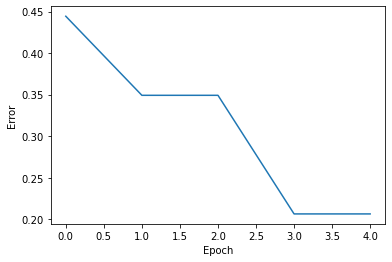

In [9]:
epochs = 5
batchsize = 100
errors = []
weights = []
K=1
alpha = 0.1
#creating datasets
train_ds = \
    tf.data.Dataset.from_tensor_slices((np.float32(trX))).batch(batchsize)
v0_state=v0
for epoch in range(epochs):
    batch_number = 0
    for batch_x in train_ds:

        for i_sample in range(len(batch_x)):           
            for k in range(K):
                v0_state = batch_x[i_sample]
                h0_state = hidden_layer(v0_state, W, hb)
                v1_state = reconstructed_output(h0_state, W, vb)
                h1_state = hidden_layer(v1_state, W, hb)

                delta_W = tf.matmul(tf.transpose([v0_state]), h0_state) - tf.matmul(tf.transpose([v1_state]), h1_state)
                W = W + alpha * delta_W

                vb = vb + alpha * tf.reduce_mean(v0_state - v1_state, 0)
                hb = hb + alpha * tf.reduce_mean(h0_state - h1_state, 0) 

                v0_state = v1_state

            if i_sample == len(batch_x)-1:
                err = error(batch_x[i_sample], v1_state)
                errors.append(err)
                weights.append(W)
                print ( 'Epoch: %d' % (epoch + 1), 
                       "batch #: %i " % batch_number, "of %i" % (len(trX)/batchsize), 
                       "sample #: %i" % i_sample,
                       'reconstruction error: %f' % err)
        batch_number += 1
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

In [10]:
mock_user_id = 8

In [11]:
inputUser = trX[mock_user_id-1].reshape(1, -1)
inputUser = tf.convert_to_tensor(trX[mock_user_id-1],"float32")
v0 = inputUser
print(v0)
v0.shape

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.33333334], shape=(7,), dtype=float32)


TensorShape([7])

In [12]:
v0test = tf.zeros([visibleUnits], tf.float32)
v0test.shape

TensorShape([7])

In [13]:
hh0 = tf.nn.sigmoid(tf.matmul([v0], W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
rec = vv1
tf.maximum(rec,1)
print(rec)
for i in vv1:
    print(i)

tf.Tensor(
[[0.42448112 0.4586111  0.5334702  0.43012863 0.6013324  0.4471749
  0.57337356]], shape=(1, 7), dtype=float32)
tf.Tensor(
[0.42448112 0.4586111  0.5334702  0.43012863 0.6013324  0.4471749
 0.57337356], shape=(7,), dtype=float32)


In [14]:
data2 = {'Category': categories, 'Recommendation Score': rec[0]}
recommendation_df = pd.DataFrame(data2)
recommendation_df.head(7)

,Category,Recommendation Score
0,1,0.424481
1,2,0.458611
2,3,0.533470
3,4,0.430129
4,5,0.601332
5,6,0.447175
6,7,0.573374
